In [1]:
# !pip install torch_geometric
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html

# from google.colab import drive
# drive.mount('/content/drive')
# adj_matrix_path = './drive/MyDrive/adj_matrix.csv'

In [2]:
import pandas as pd
import torch
from torch_geometric.nn import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
cutoff = 1500

### Generating edge list of shape (2, edges)

In [4]:
adj_matrix_path = './datasets/scats/2023/july/adj_matrix.csv'
df = pd.read_csv(adj_matrix_path, header=None)

df.shape

(609, 609)

In [5]:
# 1 if value < cutoff, 0 otherwise
df = (df < cutoff).astype(int)

In [6]:
# make a torch tensor of shape (2, num_edges)
edge_count = df.sum().sum()
edges = torch.zeros(2, edge_count, dtype=torch.int64)

# fill in the edges tensor
edge_idx = 0
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        if df.iloc[i, j] == 1:
            # cast to int because torch doesn't like numpy ints
            edges[0, edge_idx] = int(i)
            edges[1, edge_idx] = int(j)
            edge_idx += 1

In [7]:
edges.shape

torch.Size([2, 37819])

## Node2Vec

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Visualisation

In [9]:
model = Node2Vec(edges, embedding_dim=128,
                 walk_length=20,
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1,
                 p=200, q=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True)

In [10]:
edge_tuples = [tuple(x) for x in edges.numpy().transpose()]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

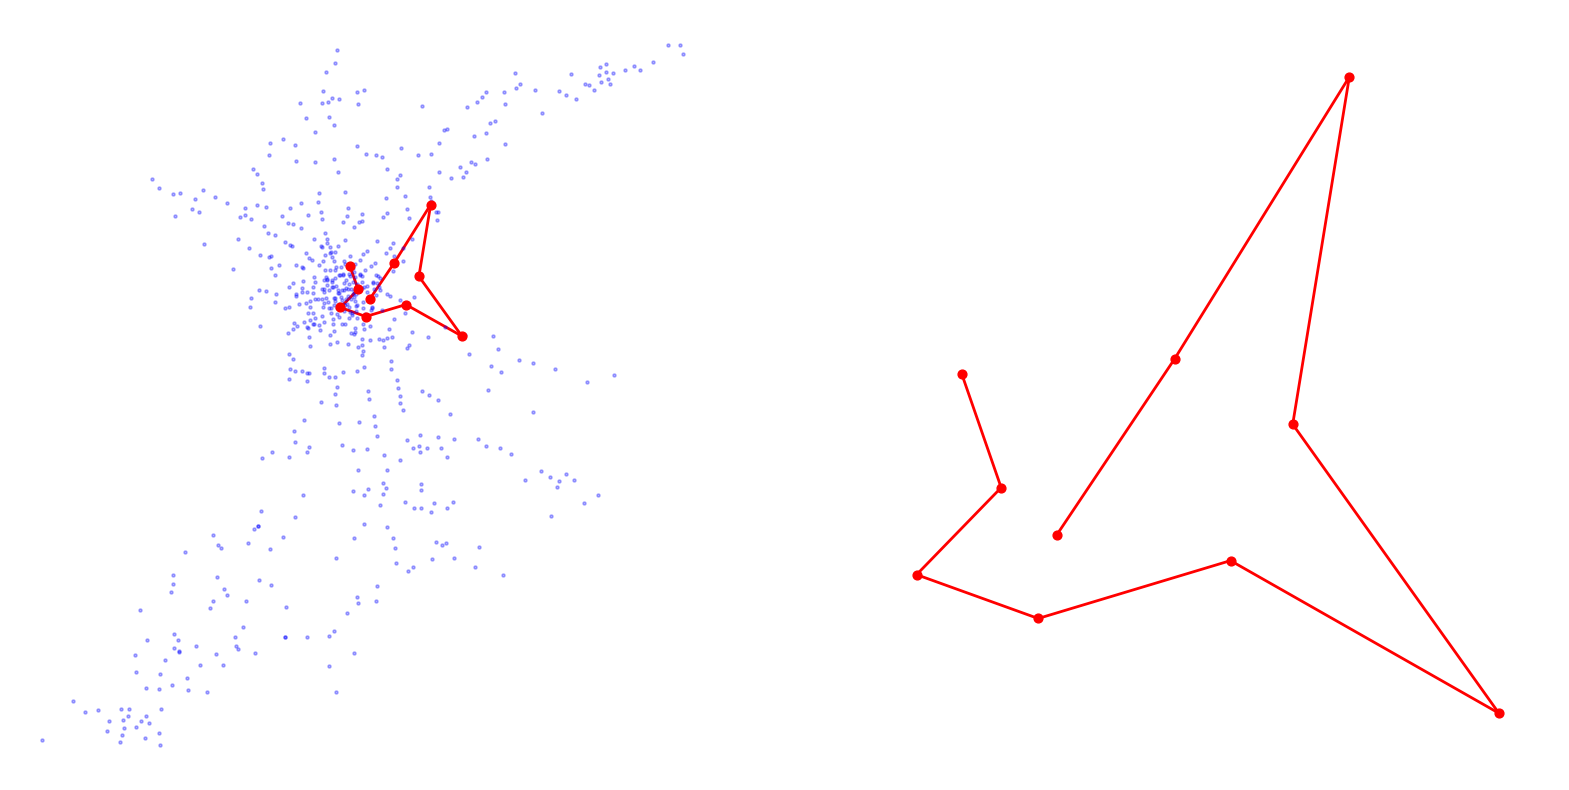

In [11]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        
        edge_color='r')

### Training

In [12]:
model = Node2Vec(edges, embedding_dim=32, walk_length=10,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
num_epochs = 200

In [13]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [14]:
for epoch in range(1, num_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

Epoch: 01, Loss: 4.6800
Epoch: 02, Loss: 4.5106
Epoch: 03, Loss: 4.2786
Epoch: 04, Loss: 4.0976
Epoch: 05, Loss: 3.9427
Epoch: 06, Loss: 3.7664
Epoch: 07, Loss: 3.6316
Epoch: 08, Loss: 3.4623
Epoch: 09, Loss: 3.3019
Epoch: 10, Loss: 3.1880
Epoch: 11, Loss: 3.0696
Epoch: 12, Loss: 2.9276
Epoch: 13, Loss: 2.8192
Epoch: 14, Loss: 2.7219
Epoch: 15, Loss: 2.6340
Epoch: 16, Loss: 2.5288
Epoch: 17, Loss: 2.4569
Epoch: 18, Loss: 2.3630
Epoch: 19, Loss: 2.2558
Epoch: 20, Loss: 2.2151
Epoch: 21, Loss: 2.1216
Epoch: 22, Loss: 2.0524
Epoch: 23, Loss: 1.9872
Epoch: 24, Loss: 1.9193
Epoch: 25, Loss: 1.8780
Epoch: 26, Loss: 1.8299
Epoch: 27, Loss: 1.7773
Epoch: 28, Loss: 1.7311
Epoch: 29, Loss: 1.6891
Epoch: 30, Loss: 1.6594
Epoch: 31, Loss: 1.6163
Epoch: 32, Loss: 1.5860
Epoch: 33, Loss: 1.5556
Epoch: 34, Loss: 1.5320
Epoch: 35, Loss: 1.4927
Epoch: 36, Loss: 1.4655
Epoch: 37, Loss: 1.4419
Epoch: 38, Loss: 1.4195
Epoch: 39, Loss: 1.4017
Epoch: 40, Loss: 1.3728
Epoch: 41, Loss: 1.3703
Epoch: 42, Loss:

### View embeddings

In [15]:
emb = model()
emb.shape

torch.Size([609, 32])

### Save embeddings


In [16]:
embeddings_path = './datasets/scats/2023/july/embeddings.pt'
torch.save(emb, embeddings_path)